In [2]:
from ngauge import Neuron
from glob import glob
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from brainlit.utils.Neuron_trace import NeuronTrace
from brainlit.algorithms.trace_analysis.fit_spline import GeometricGraph
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import splev

from tqdm import tqdm

In [3]:
files = glob('/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/axon_geometry/data/brain1/segments_swc/*.swc')
neuron = Neuron.from_swc("/Users/thomasathey/Documents/mimlab/mouselight/brainlit_parent/brainlit/experiments/axon_geometry/data/brain1/segments_swc/2018-08-01_G-073_consensus.swc")

  0%|          | 0/180 [00:00<?, ?it/s]

1450 total main branch nodes


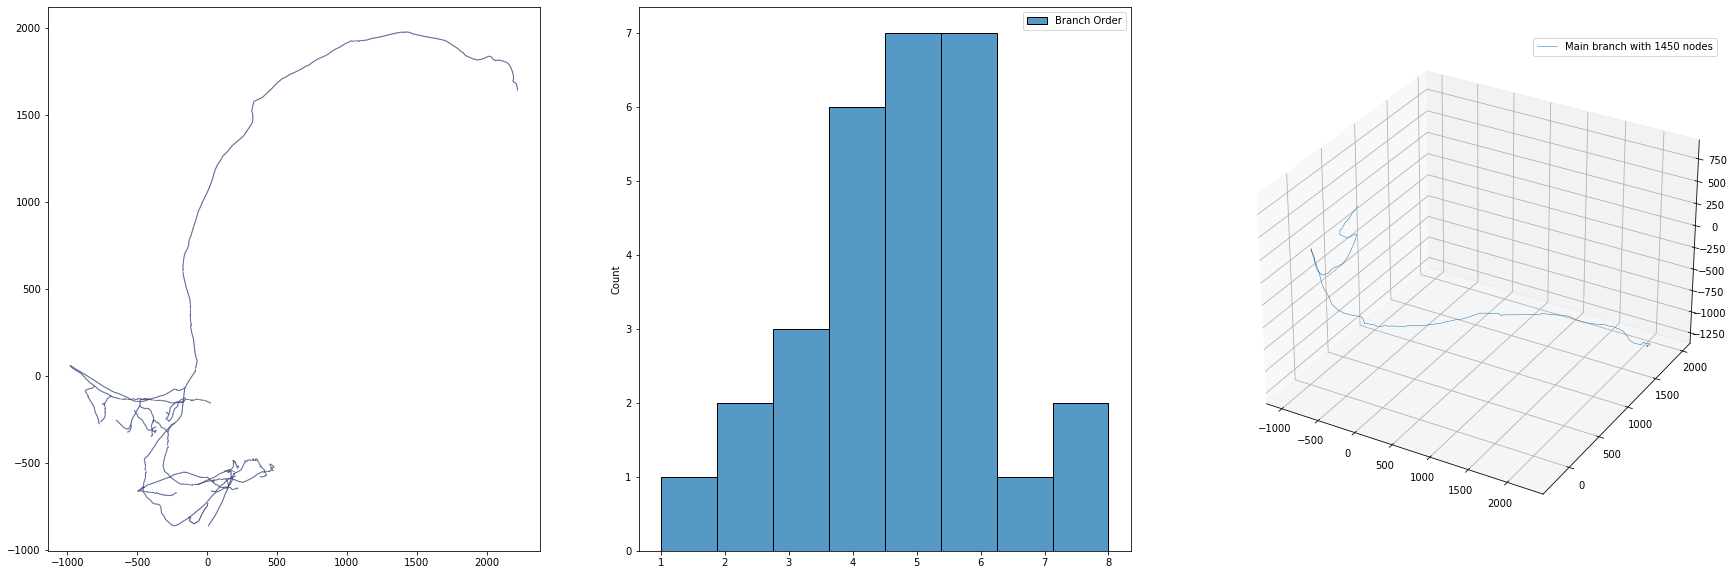

  1%|          | 1/180 [00:03<11:09,  3.74s/it]

183 total main branch nodes


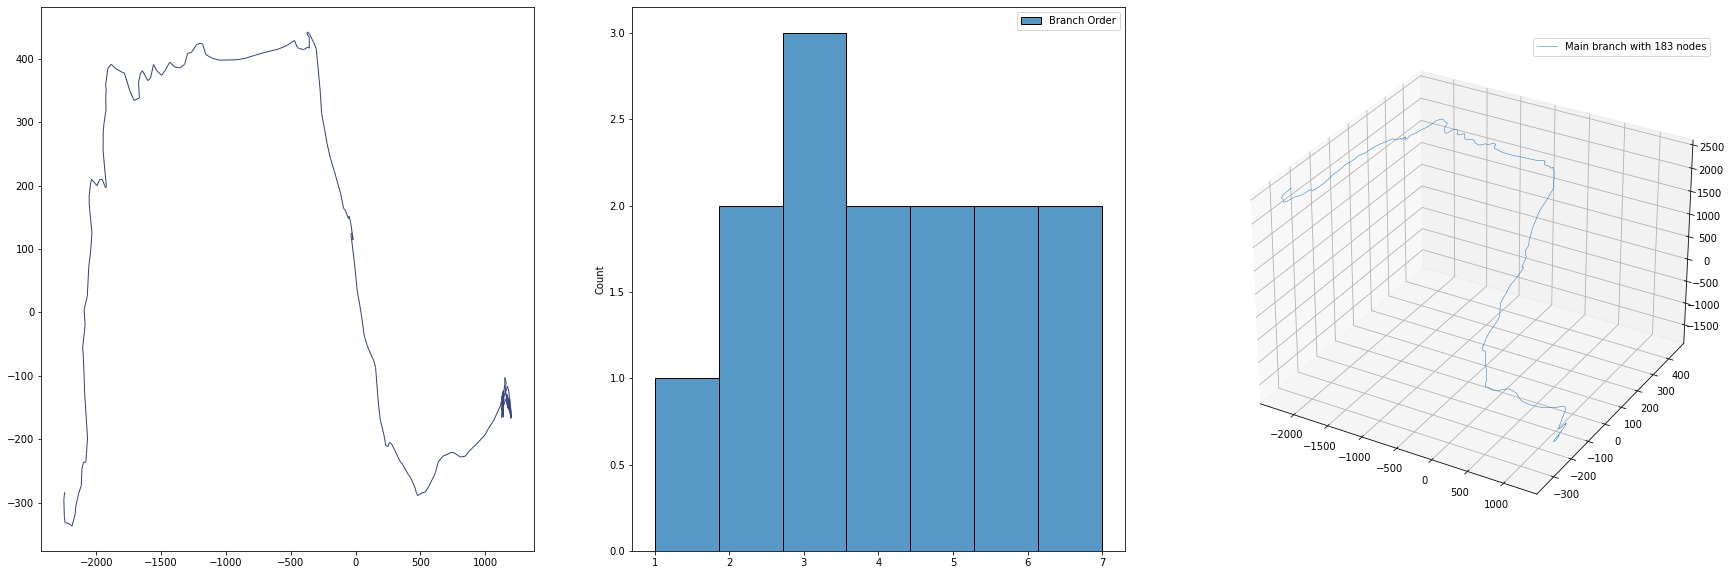

  1%|          | 2/180 [00:04<05:57,  2.01s/it]

45 total main branch nodes


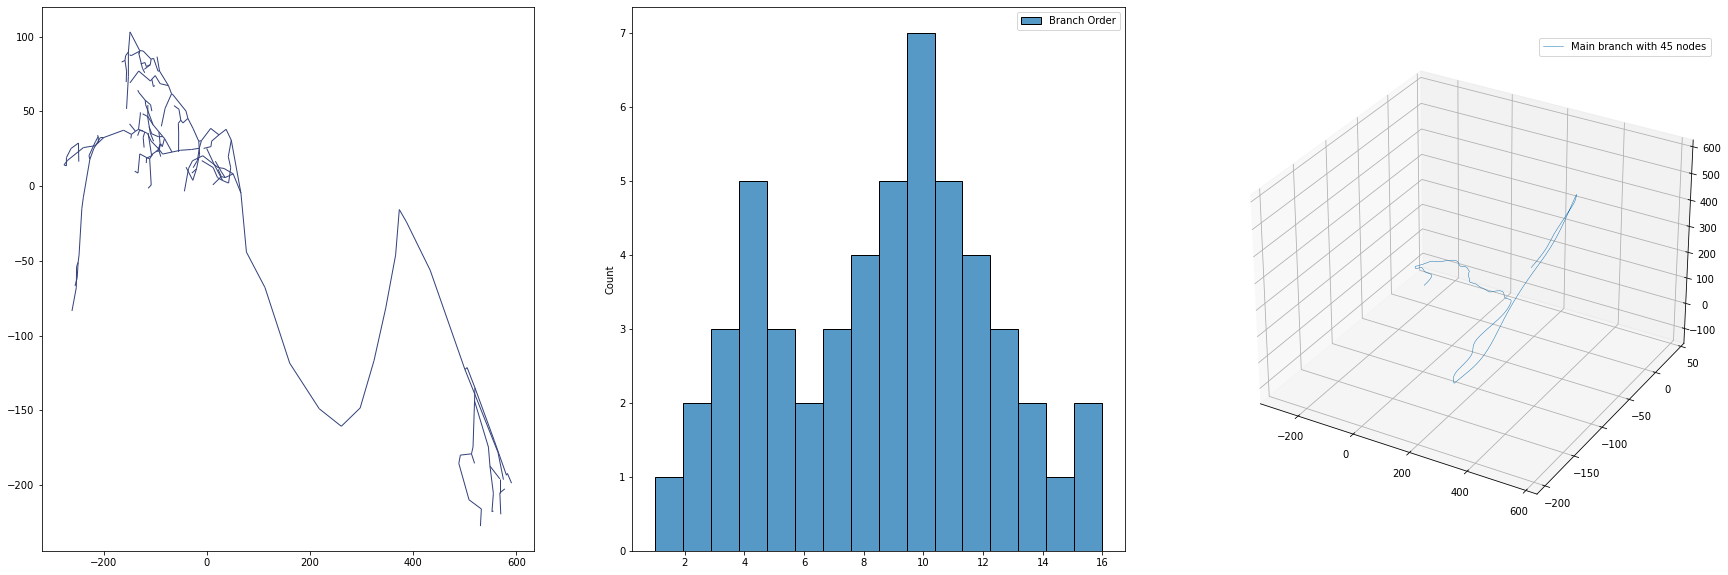

  2%|▏         | 3/180 [00:05<04:12,  1.43s/it]

1178 total main branch nodes


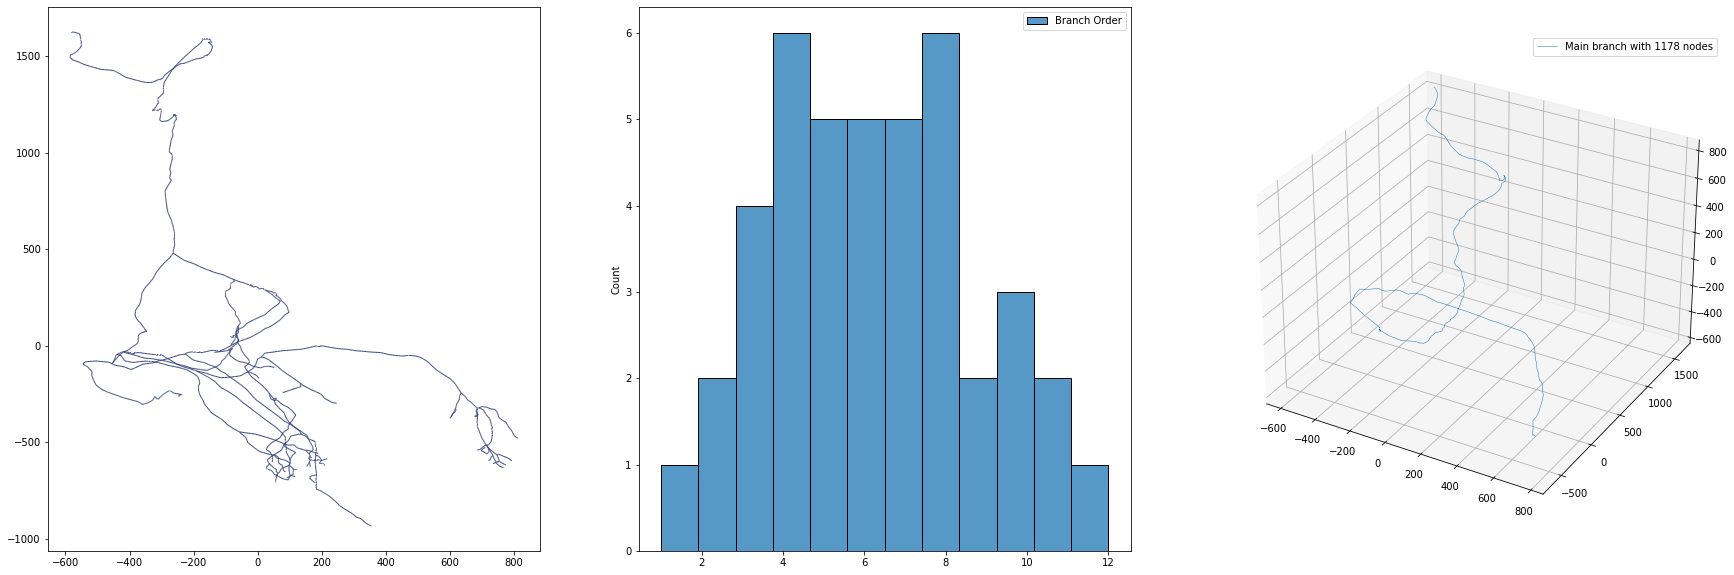

  2%|▏         | 4/180 [00:09<07:18,  2.49s/it]

84 total main branch nodes


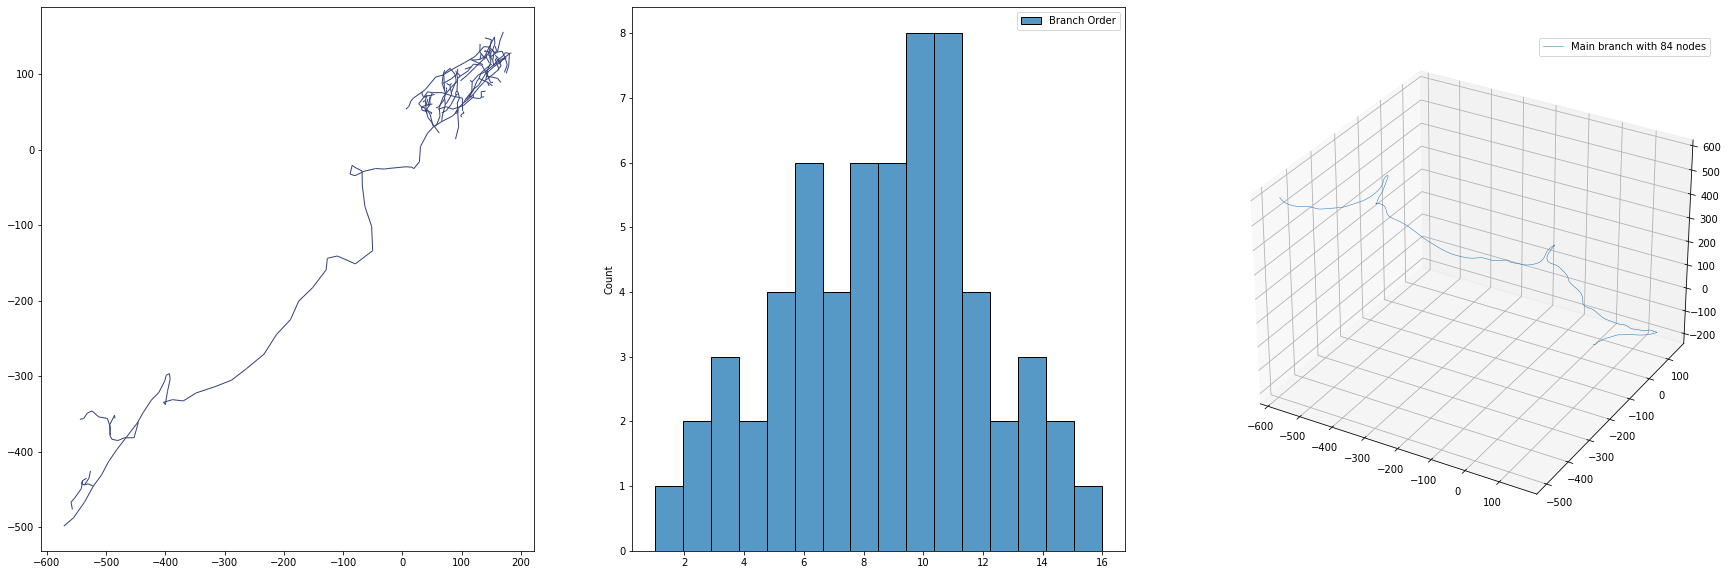

100%|██████████| 180/180 [07:51<00:00,  2.62s/it]


<AxesSubplot:xlabel='Nodes in Main Branch', ylabel='Count'>

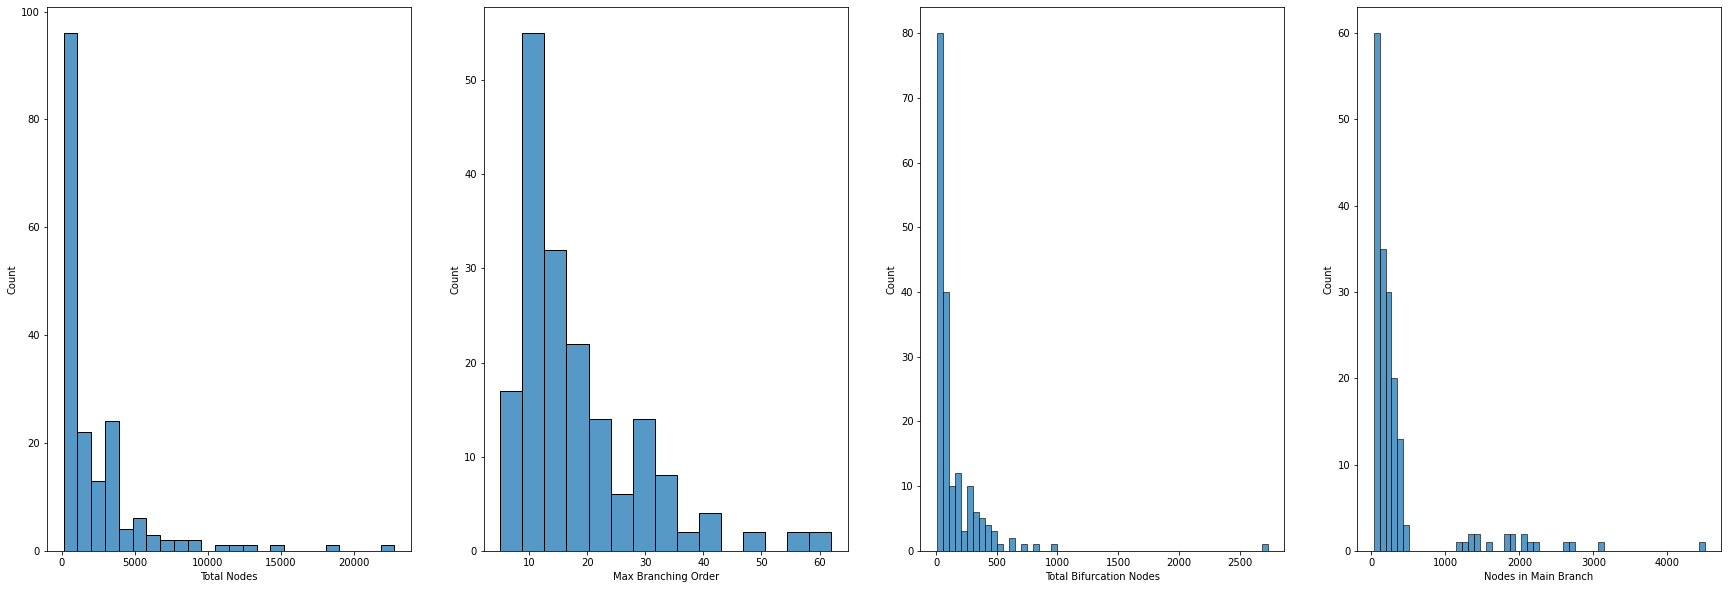

In [11]:
total_trace_points = []
max_branching_orders = []
total_bif_nodes = []
main_branch_nodes = []

for i, file in enumerate(tqdm(files)):
    neuron =  Neuron.from_swc(file)
    total_trace_points.append(neuron.total_child_nodes())
    max_branching_orders.append(neuron.max_branching_order())
    total_bif_nodes.append(neuron.total_bif_nodes())

    swc_trace = NeuronTrace(path=file)
    df_swc_offset_neuron = swc_trace.get_df()

    G = GeometricGraph(df=df_swc_offset_neuron)
    spline_tree = G.fit_spline_tree_invariant()

    for j, node in enumerate(spline_tree.nodes):
        spline = spline_tree.nodes[node]
        if len(list(spline_tree.predecessors(node))) == 0:
            tck, u_um = spline["spline"]
            main_branch_nodes.append(len(u_um))
            y = splev(np.arange(u_um[0], u_um[-1], 0.1), tck)
            break
    
    # Plot 
    if i < 5:
        fig = plt.figure(figsize=(30,10))

        ax = fig.add_subplot(1,3,1)
        neuron.plot(fig=None, ax=ax, color=(52/256, 66/256, 123/256) )

        counts = neuron.branch_order_counts()
        data = []
        for i,c in enumerate(counts):
            data += c*[i+1]
        ax = fig.add_subplot(1,3,2)
        data = {"Branch Order": data}
        sns.histplot(data, bins = len(np.unique(data["Branch Order"])), ax=ax)
        
        ax = fig.add_subplot(1,3,3, projection='3d')

        print(f"{len(u_um)} total main branch nodes")
        ax.plot(y[0], y[1], y[2], linewidth=0.5, label=f"Main branch with {len(u_um)} nodes")
        ax.legend()
        plt.show()


data = {"Total Nodes": total_trace_points, "Max Branching Order": max_branching_orders, "Total Bifurcation Nodes": total_bif_nodes, "Nodes in Main Branch": main_branch_nodes}

df = pd.DataFrame(data=data)


fig, axs = plt.subplots(1,4, figsize=(30,10))
sns.histplot(data=df, x="Total Nodes", ax=axs[0])
sns.histplot(data=df, x="Max Branching Order", ax=axs[1])
sns.histplot(data=df, x="Total Bifurcation Nodes", ax=axs[2])
sns.histplot(data=df, x="Nodes in Main Branch", ax=axs[3])


<AxesSubplot:xlabel='Angle Difference'>

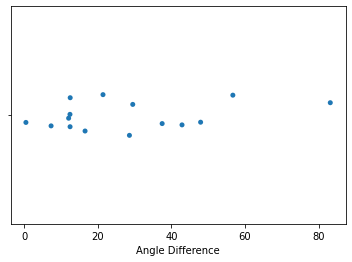

In [49]:
branch_points = neuron.all_branch_points()

angle_dif = []
rel_size = []
for b in branch_points:
    n_children = len(b.children)
    a0 = b.angle(b.parent, b.children[0])
    a1 = b.angle(b.parent, b.children[1])

    angle_dif.append(np.abs(a1-a0))

data = {"Angle Difference": angle_dif}
df = pd.DataFrame(data=data)

sns.stripplot(data=df, x="Angle Difference")